# Other T cell subclustering and markers

In this notebook, we use marker gene detection to select clusters that contain T cells that weren't subclustered in other sets, then subset our dataset and perform a round of iterative clustering.

The outputs of this analysis are used by our domain experts to assign cell type identities to our reference.

## Load packages

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
import copy
from datetime import date
import hisepy
import os
import pandas as pd 
import re
import scanpy as sc
import scanpy.external as sce

## Helper functions

These functions will help with subsetting and performing leiden clustering at multiple resolutions in parallel.

`select_clusters_by_gene_frac()` allows us to compute the fraction of cells in each cluster that express the provided gene (> 0 UMIs). This fraction is provided by `scanpy`'s dotplot function, which calculates these fractions for use in display. We then filter clusters based on the cutoff provided as a parameter to this function.

In [2]:
def select_clusters_by_gene_frac(adata, gene, cutoff, clusters = 'leiden'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = gene,
        return_fig = True
    ).dot_size_df

    select_cl = gene_cl_frac.index[gene_cl_frac[gene] > cutoff].tolist()

    return select_cl

In [3]:
def read_parquet_uuid(pq_uuid):
    pq_path = '/home/jupyter/cache/{u}'.format(u = pq_uuid)
    if not os.path.isdir(pq_path):
        hise_res = hisepy.reader.cache_files([pq_uuid])
    pq_filename = os.listdir(pq_path)[0]
    pq_file = '{p}/{f}'.format(p = pq_path, f = pq_filename)
    df = pd.read_parquet(pq_file)
    return df

## Read full dataset from HISE

In [4]:
cell_class = 't-other'

In [5]:
h5ad_uuid = 'd6ebc576-34ea-4394-a569-e35e16f20253'
h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)

In [6]:
if not os.path.isdir(h5ad_path):
    hise_res = hisepy.reader.cache_files([h5ad_uuid])

In [7]:
h5ad_filename = os.listdir(h5ad_path)[0]
h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)

In [8]:
adata = sc.read_h5ad(h5ad_file)

In [9]:
adata

AnnData object with n_obs × n_vars = 1191327 × 1487
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'file.id', 'subject.cmv', 'subject.bmi', 'celltypist.low', 'seurat.l1', 'seurat.l1.score', 'seurat.l2', 'seurat.l2.score', 'seurat.l2.5', 'seurat.l2.5.score', 'seurat.l3', 'seurat.l3.score', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden', 'leiden_resolution_1', 'leiden_res

## Read all other T cell subsets from HISE and filter

In [12]:
in_uuids = [
    '979c9314-5c4f-4da2-a674-cc099cd06412',  # Naive CD4 T cell .parquet
    'a1ecdac3-1332-4411-a135-41b94977b6c0',  # MAIT CD8 T cell .parquet
    'f46939aa-424e-433d-8b0d-45ea77d7308d',  # CM CD8 T cell .parquet
    '39f48474-671d-4584-a10e-e1dd47b33dac',  # EM CD8 T cell .parquet
    '8f76dce0-81ec-45c9-9612-68bddcecdd8b',  # Treg cell .parquet
    '9fb15399-7867-4ea9-b4a1-bcbf2d29e0a1',  # Naive CD8 T cell .parquet
    '5043bfef-7430-413b-af8d-411e3578dab6',  # Proliferating T cell .parquet
    'ebedbccf-bb5f-4e9e-be6f-df6cc5fd6607',  # gdT cell .parquet
    'c6be4029-b822-4558-9629-f33b96e227c5'   # ISG-high T cell .parquet
]

In [13]:
in_obs = []
for uuid in in_uuids:
    obs = read_parquet_uuid(uuid)
    in_obs.append(obs)

downloading fileID: ebedbccf-bb5f-4e9e-be6f-df6cc5fd6607
Files have been successfully downloaded!


In [14]:
t_bc = adata.obs['barcodes']
for obs in in_obs:
    drop_bc = t_bc.isin(obs['barcodes'])
    keep_bc = [not bc for bc in drop_bc]
    t_bc = t_bc[keep_bc]

In [15]:
keep_bc = t_bc.to_list()

In [16]:
adata_subset = adata[keep_bc]

In [17]:
adata_subset.shape

(376762, 1487)

## Normalize and harmonize subset

As in the original analysis of this dataset, we'll need to normalize, select marker genes, and run Harmony to integrate across our cohorts.

It's important that we redo this step for our subset, as gene variability may differ when computed within our subset of cells rather than across the entire set of PBMCs. This key feature selection step will affect our ability to cluster and identify cell types, so we do this iteratively for the subset we're using now.

We previously stored raw counts in `adata.raw` - we can now recover these original count data for analysis of the selected cells:

In [18]:
adata_subset = adata_subset.raw.to_adata()

In [19]:
adata_subset.shape

(376762, 33538)

In [20]:
adata_subset.raw = adata_subset

In [21]:
sc.pp.normalize_total(adata_subset, target_sum=1e4)

In [22]:
sc.pp.log1p(adata_subset)
sc.pp.highly_variable_genes(adata_subset)
adata_subset = adata_subset[:, adata_subset.var_names[adata_subset.var['highly_variable']]]

In [23]:
sc.pp.scale(adata_subset)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [24]:
sc.tl.pca(adata_subset, svd_solver='arpack')

In [25]:
sce.pp.harmony_integrate(
    adata_subset, 
    'cohort.cohortGuid',
    max_iter_harmony = 30)

2024-03-02 03:21:47,006 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-02 03:23:51,823 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-02 03:23:53,299 - harmonypy - INFO - Iteration 1 of 30
2024-03-02 03:26:29,663 - harmonypy - INFO - Iteration 2 of 30
2024-03-02 03:29:12,048 - harmonypy - INFO - Iteration 3 of 30
2024-03-02 03:31:59,462 - harmonypy - INFO - Iteration 4 of 30
2024-03-02 03:33:59,041 - harmonypy - INFO - Iteration 5 of 30
2024-03-02 03:35:27,181 - harmonypy - INFO - Converged after 5 iterations


In [26]:
sc.pp.neighbors(
    adata_subset, 
    n_neighbors = 50,
    use_rep = 'X_pca_harmony', 
    n_pcs = 30)

In [27]:
sc.tl.umap(adata_subset, min_dist = 0.05)

In [28]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [29]:
subset_h5ad = 'output/pbmc_ref_{c}_subset_{d}.h5ad'.format(c = cell_class, d = date.today())
adata_subset.write_h5ad(subset_h5ad)

## Cluster with additional resolution


In [30]:
%%time
sc.tl.leiden(
    adata_subset, 
    resolution = 1.5, 
    key_added = 'leiden_resolution_1.5_{c}'.format(c = cell_class)
)

CPU times: user 1h 39min 36s, sys: 1min 28s, total: 1h 41min 5s
Wall time: 1h 40min 32s


In [31]:
clustered_h5ad = 'output/pbmc_ref_{c}_clustered_{d}.h5ad'.format(c = cell_class, d = date.today())
adata_subset.write_h5ad(clustered_h5ad)

## Plot reference labels and clustering

Now that we've clustered, it's helpful to plot reference labels and clusters on our UMAP projection to see how they fall relative to each other.

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'seurat.l2.5'}, xlabel='UMAP1', ylabel='UMAP2'>

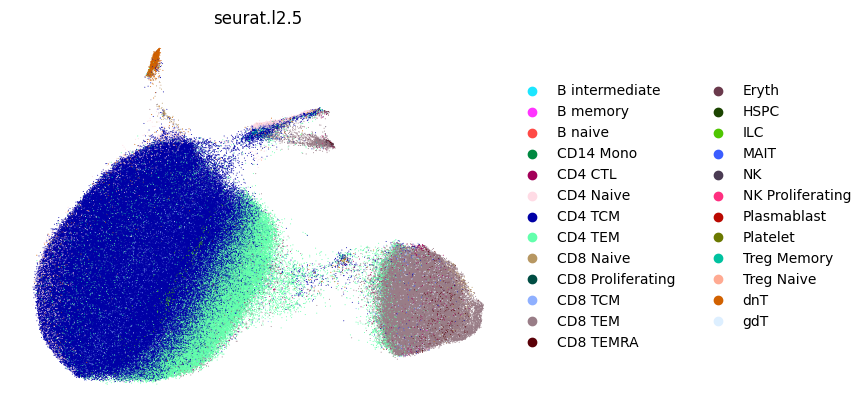

In [32]:
sc.pl.umap(
    adata_subset, 
    color = ['seurat.l2.5'], 
    size = 2,
    show = False,
    ncols = 1 ,
    frameon = False
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'celltypist.low'}, xlabel='UMAP1', ylabel='UMAP2'>

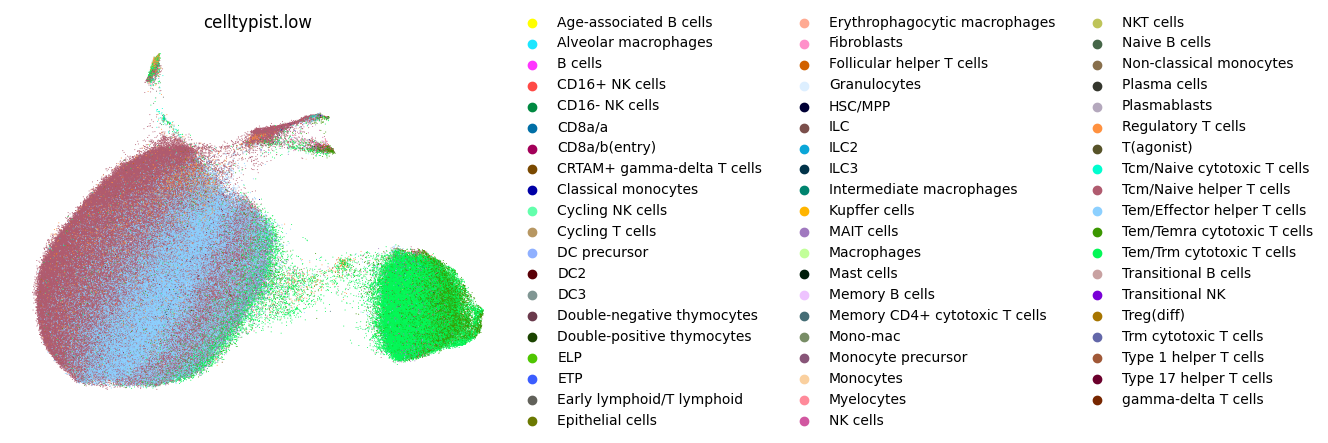

In [33]:
sc.pl.umap(
    adata_subset, 
    color = ['celltypist.low'], 
    size = 2,
    show = False,
    ncols = 1 ,
    frameon = False
)

CMV status is also helpful to view, as CMV can drive expansion of some cell types.

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'subject.cmv'}, xlabel='UMAP1', ylabel='UMAP2'>

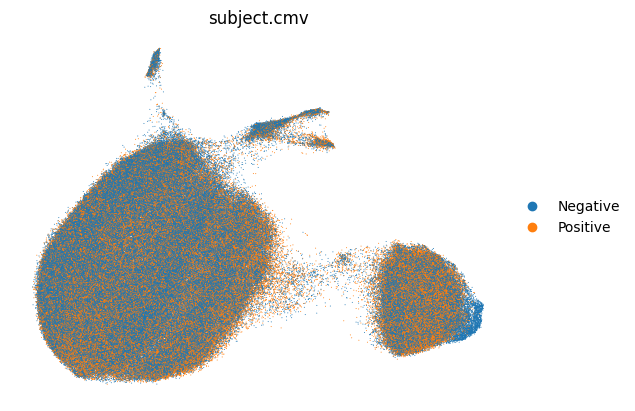

In [34]:
sc.pl.umap(
    adata_subset, 
    color = ['subject.cmv'], 
    size = 2,
    show = False,
    ncols = 1 ,
    frameon = False
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'leiden_resolution_1.5_t-other'}, xlabel='UMAP1', ylabel='UMAP2'>

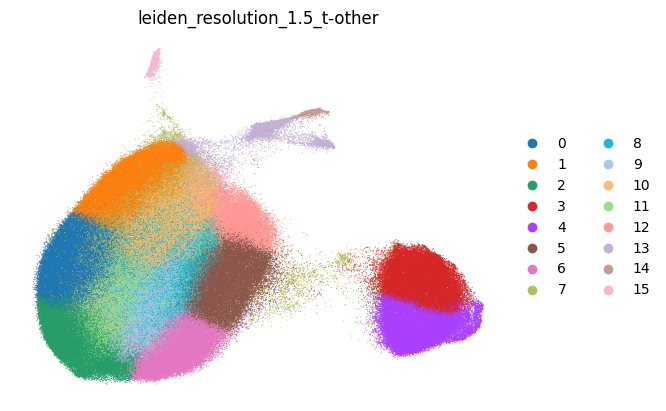

In [35]:
sc.pl.umap(
    adata_subset, 
    color = 'leiden_resolution_1.5_{c}'.format(c = cell_class), 
    size = 2,
    show = False,
    ncols = 1 ,
    frameon = False
)

## Save UMAP coordinates and labels

In [36]:
umap_mat = adata_subset.obsm['X_umap']

In [37]:
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])

In [38]:
obs = adata_subset.obs
obs['umap_1'] = umap_df['umap_1']
obs['umap_2'] = umap_df['umap_2']

In [39]:
out_csv = 'output/ref_pbmc_{c}_clustered_umap_meta_{d}.csv'.format(c = cell_class, d = date.today())

In [40]:
obs.to_csv(out_csv)

/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/

In [41]:
out_parquet = 'output/pbmc_ref_{c}_clustered_umap_meta_{d}.parquet'.format(c = cell_class, d = date.today())

In [42]:
obs = obs.to_parquet(out_parquet)

## Compute markers for Leiden clustering

In [43]:
adata_subset = adata_subset.raw.to_adata()
sc.pp.normalize_total(adata_subset, target_sum=1e4)
sc.pp.log1p(adata_subset)

In [44]:
sc.tl.rank_genes_groups(adata_subset, 'leiden_resolution_1.5_{c}'.format(c = cell_class), method = 'wilcoxon')
df = sc.get.rank_genes_groups_df(adata_subset, group = None)

In [45]:
res_csv = '{p}/pbmc_ref_{c}_res{n}_markers_{d}.csv'.format(p = out_dir, c = cell_class, n = 2, d = date.today())
df.to_csv(res_csv)
marker_files = res_csv

## Upload assembled data to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [46]:
study_space_uuid = '64097865-486d-43b3-8f94-74994e0a72e0'
title = 'Other T cell subclustering {d}'.format(d = date.today())

In [47]:
in_files = [h5ad_uuid]

In [48]:
in_files

['d6ebc576-34ea-4394-a569-e35e16f20253']

In [49]:
out_files = [clustered_h5ad, out_csv, out_parquet, marker_files]

In [50]:
out_files

['output/pbmc_ref_t-other_clustered_2024-03-02.h5ad',
 'output/ref_pbmc_t-other_clustered_umap_meta_2024-03-02.csv',
 'output/pbmc_ref_t-other_clustered_umap_meta_2024-03-02.parquet',
 'output/pbmc_ref_t-other_res2_markers_2024-03-02.csv']

In [51]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files
)

output/pbmc_ref_t-other_clustered_2024-03-02.h5ad
output/ref_pbmc_t-other_clustered_umap_meta_2024-03-02.csv
output/pbmc_ref_t-other_clustered_umap_meta_2024-03-02.parquet
output/pbmc_ref_t-other_res2_markers_2024-03-02.csv
Cannot determine the current notebook.
1) /home/jupyter/scRNA-Reference-IH-A/03-Subclustering/11j-Python_T_cells_other.ipynb
2) /home/jupyter/scRNA-Reference-IH-A/03-Subclustering/11h-Python_T_cells_gd.ipynb
3) /home/jupyter/scRNA-Reference-IH-A/03-Subclustering/11d-Python_T_cells_cd8-em.ipynb
Please select (1-3) 


 1


you are trying to upload file_ids... ['output/pbmc_ref_t-other_clustered_2024-03-02.h5ad', 'output/ref_pbmc_t-other_clustered_umap_meta_2024-03-02.csv', 'output/pbmc_ref_t-other_clustered_umap_meta_2024-03-02.parquet', 'output/pbmc_ref_t-other_res2_markers_2024-03-02.csv']. Do you truly want to proceed?


(y/n) y


{'trace_id': 'ca51f83f-e5c1-4492-9c2c-23eb9ae2802c',
 'files': ['output/pbmc_ref_t-other_clustered_2024-03-02.h5ad',
  'output/ref_pbmc_t-other_clustered_umap_meta_2024-03-02.csv',
  'output/pbmc_ref_t-other_clustered_umap_meta_2024-03-02.parquet',
  'output/pbmc_ref_t-other_res2_markers_2024-03-02.csv']}

In [52]:
import session_info
session_info.show()